In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import mrcfile

# Load density map

In [3]:
data_directory = pathlib.Path('..') / 'data'  # directory where the data is
map_dir = data_directory / 'EMPIAR' / '10077'

In [5]:
id = 4121
fname = f'emd_{id}.map.gz'

In [10]:
with mrcfile.open(f'{str(map_dir)}/{fname}') as mrc:
    volume = mrc.data
print(f'> Loaded map of shape: {volume.shape}')

> Loaded map of shape: (272, 272, 272)


In [11]:
def show_volume(volume, mode='sum', axis='Z', bins=100):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(121)
    display_volume(volume, mode=mode, axis=axis, dimension=2)
    plt.subplot(122)
    display_hist(volume.flatten(), bins=bins)
    plt.show()
    
def display_volume(volume, mode='sum', axis='Z', dimension=2, cmap='Greys'):
    #display_dimension = 2
    nx = volume.shape[0]
    if(dimension < 3):
        if(mode=='sum'):
            if(axis=='X'):
                numaxis=0
            elif(axis=='Y'):
                numaxis=1
            elif(axis=='Z'):
                numaxis=2
            plt.imshow(np.sum(volume,axis=numaxis), cmap=cmap)
        elif(mode=='slice'):
            if(axis=='X'):
                plt.imshow(volume[int(nx/2),...], cmap=cmap)
            elif(axis=='Y'):
                plt.imshow(volume[:,int(nx/2),:], cmap=cmap)
            elif(axis=='Z'):
                plt.imshow(volume[:,:,int(nx/2)], cmap=cmap)
        plt.colorbar()

def display_hist(volume, bins=10):
    plt.hist(volume, bins=bins, log=True, color='grey')
    plt.grid()
    plt.show()

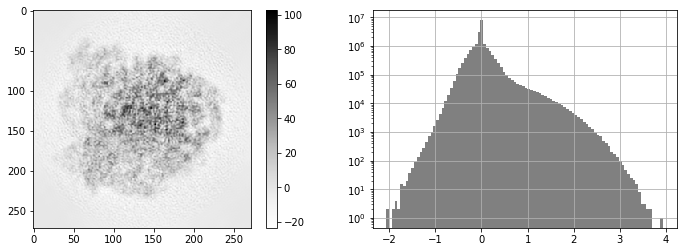

In [12]:
show_volume(volume)

# Create density map
here we just define a few randomly placed atoms. We could also read their cartesian coordinates from a PDB file (to be done).

In [13]:
def init_crds(natom=2, R=10.):
    """init_crds"""
    crds  = np.random.rand(natom, 3)*R
    crds -= np.mean(crds, axis=0)
    rads  = 1*np.ones(natom)
    return crds, rads

def init_volume(n, L, crds=None, rads=None):
    """init_volume: WAY TO SLOW, TO BE OPTIMIZED
    """
    index  = np.arange(n)
    volume = np.zeros((n,n,n))
    for i in index:
        posx = -L/2 + i*L/(n-1)
        for j in index:
            posy = -L/2 + j*L/(n-1)
            for k in index:
                posz = -L/2 + k*L/(n-1)
                for iat in np.arange(crds.shape[0]):
                    dx = crds[iat,0] - posx
                    dy = crds[iat,1] - posy
                    dz = crds[iat,2] - posz
                    dist2  = dx*dx + dy*dy + dz*dz
                    if(dist2 <= 100):
                        dist2 /= rads[iat]**2
                        volume[i,j,k] += np.exp(-0.5*dist2)
    return volume

In [14]:
atomic_coordinates, atomic_radii = init_crds(natom=10)
density_volume = init_volume(32, 25., 
                             crds=atomic_coordinates,
                             rads=atomic_radii)

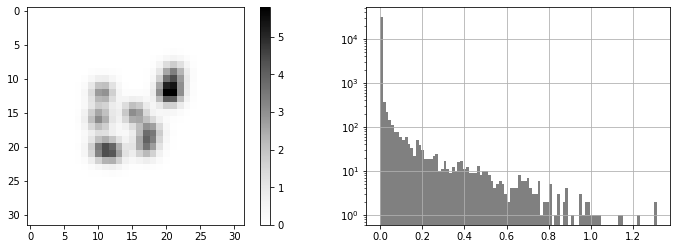

In [15]:
show_volume(density_volume)